# Analysis of NYC Citi Bike Share System

## Business Understanding
Since 2013, the Citi Bike share program has been implemented in New York City as a means of promoting cleaner, healthier modes of transportation. It has helped reduce the usage of gas-powered vehicles and encouraged healthier ways of living.

The Bike Share system is currently managed by Lyft; however, many drawbacks and issues persist. For example, a 2023 study of the system noted that a majority of bike stations in low-income areas, such as the Bronx, typically do not have bikes available for at least an hour. Many bikes in these areas also do not receive adequate maintenance.

In this study, we will analyze bike ride data to understand the behavior of riders during July, one of the busiest months of the year. We will address the following questions:

1. Which boroughs have the most stations?
2. When are bikers most actively riding?
3. Which stations receive bikes from the most stations? Which stations send bikes to the most stations?
4. Can we identify any monotonic relationships for future modeling?

By understanding which boroughs have more stations, we can better understand which boroughs require more stations. Understanding when bikers are most active allows us to identify peak usage times, so maintenance staff can avoid servicing bikes during these periods. 

One significant, ongoing issue is the reallocation of bikes to different stations. By analyzing the relationships between stations and rider activity, we can better understand where bikes should be reallocated. Lastly, we aim to determine whether the historical data provide any monotonic relationships—defined as relationships where features and target values either increase together or decrease together. This insight will motivate the development and selection of machine learning models for future prediction tasks.


## Data Understanding

The Citi Bike Share system was sponsored by Citi Bank and managed by Alta Bikeshare from 2013 to 2015. In 2015, Alta Bikeshare rebranded as Motivate, and by the end of their management tenure, they had expanded to 754 stations and 12,000 bikes—doubling the bike share footprint from three years prior. In 2018, Lyft, the ride-share app, acquired Motivate and has since managed the Bike Share system.

The historical bike share data can be found [here](https://s3.amazonaws.com/tripdata/index.html), and general information about each bike station can also be obtained [here](https://gbfs.lyft.com/gbfs/2.3/bkn/en/station_information.json). The data provides various information such as the geographical coordinates of the stations, which stations a bike began its ride from, and where the bike was parked at the end of the ride.

In [17]:
# ---- LIBRARY IMPORTS ----
import pandas as pd
import datetime
import requests
from datetime import datetime
from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from shapely.geometry import shape
from shapely.geometry import Point
from shapely import Polygon
import folium

In [2]:
# ---- READING IN DATASETS ----
#  Bike ride data
usecols = [index for index in range(1, 14)]
dtype = {'ride_id': "string", 'rideable_type': "string", 'started_at': "string", 'ended_at': "string", 'start_station_name': "string",
         'start_station_id': "string", 'end_station_name': "string", 'end_station_id': "string", 'start_lat': float,
         'start_lng': float, 'end_lat': float, 'end_lng': float, 'member_casual': "string"}
df = pd.read_csv('data/202407-citibike-tripdata_5.csv', usecols=usecols, dtype=dtype)

# Bike station information
station_info_url = "https://gbfs.lyft.com/gbfs/2.3/bkn/en/station_information.json"
station_info_dict = requests.get(station_info_url).json()
station_info_list = station_info_dict.get("data").get("stations")
# Get dataframe of station info
station_info = pd.DataFrame(station_info_list)

# Polygon Coordinates
polygon_coordinates_url = "https://data.cityofnewyork.us/resource/7t3b-ywvw.json"
polygon_coordinates_list = requests.get(polygon_coordinates_url).json()

borough_polygon_dict = {}

for dict_ in polygon_coordinates_list:
    borough_name = dict_.get('boro_name')
    borough_multipolygon = dict_.get('the_geom')#.get('coordinates')
    borough_polygon_dict.update({borough_name: shape(borough_multipolygon)})

In [3]:
borough_polygon_dict
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,557426B1CE207702,electric_bike,2024-07-17 19:30:15.471,2024-07-17 19:34:22.646,Sullivan St & Washington Sq,5721.01,E 12 St & 3 Ave,5788.12,40.730477,-73.999061,40.732233,-73.988900,member
1,A60E366FEE8B51E8,electric_bike,2024-07-15 19:17:52.523,2024-07-15 19:25:24.399,Sullivan St & Washington Sq,5721.01,Forsyth St & Grand St,5382.07,40.730477,-73.999061,40.717798,-73.993161,member
2,ACA30207F80B5DF9,classic_bike,2024-07-27 13:34:48.531,2024-07-27 13:49:55.913,W 37 St & 10 Ave,6611.02,Perry St & Bleecker St,5922.07,40.756604,-73.997901,40.735354,-74.004831,member
3,B3A138C956E9A729,electric_bike,2024-07-23 11:01:36.895,2024-07-23 11:06:02.796,Melrose St & Broadway,4801.04,Nostrand Ave & Myrtle Ave,4707.04,40.697481,-73.935877,40.695270,-73.952381,member
4,EA0BFE3B299B0672,electric_bike,2024-07-16 19:19:15.034,2024-07-16 19:50:39.140,Melrose St & Broadway,4801.04,W 27 St & 7 Ave,6257.06,40.697481,-73.935877,40.746650,-73.993920,member


## Data Preparation
The following operations are required for data cleaning

1. Encode `rideable_type` and `member_casual`
2. Create fields for `start_date`, `start_time`, `end_date`, `end_time`
3. Create field for trip duration
4. Create distance between stations using the [Manhattan's Distance](https://www.datacamp.com/tutorial/manhattan-distance)
5. Drop any rows with missing station IDs
6. Create labels for station borough location

## Encoding Binary Variables
The `rideable_type` and `member_casual` fields will use dummy encoding using pandas' [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) method.

In [4]:
df = pd.get_dummies(data=df, columns=['rideable_type', 'member_casual'], dtype="int", drop_first=True)

## Drop any NA values
We want to drop any values with `Null` for missing station IDs, names, ride IDs, coordinates or names because if any of them are `Null`, then we cannot understand what what on during a ride.

In [5]:
df.dropna(subset=['ride_id', 'started_at', 'ended_at', 'start_station_name', 'start_station_id',
                  'end_station_id', 'end_station_name', 'start_lat', 'end_lat', 'end_lng', 'end_lng'], inplace=True)

## Create fields for `start_date`, `start_time`, `end_date`, `end_time`
For ease of use of time and date information, we will split the`started_at` and `ended_at`fields from `datetime` data type to `date` and `timestamp` respectively.

In [6]:
# Convert strings to datetime datatypes
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extract date and time values respectively
date_map = lambda val: val.date()
time_map = lambda val: val.time()

# Create columns
df['start_date'] = df['started_at'].map(date_map)
df['end_date'] = df['ended_at'].map(date_map)
df['start_time'] =  df['started_at'].map(time_map)
df['end_time'] = df['ended_at'].map(time_map)

## Create field for trip_duration
We will now create the `trip_duration` field that describes the trip duration.  We will used the _Manhattan's distance_ because New York City is designed in a grid like system and the Manhattan's distance works well with this type of structure.  

In [7]:
# Create timedelta datatype
trip_duration = df['ended_at'] - df['started_at']

# Get total seconds from timedelta
get_trip_seconds = lambda val: val.total_seconds()
df['trip_duration'] = trip_duration.map(get_trip_seconds)

## Get Distance Between All Stations
We now will capture the distances between all stations using the [Manhattan's Distance](https://www.datacamp.com/tutorial/manhattan-distance), which is computed as follows

$$
d = |lat_{start} - lat_{end}| + |lon_{start} - lon_{end}|
$$

In [8]:
def haversine_map(row):
    """
    haversine_map: returns the haversine distance between the start and end stations of a ride in a dataframe
    input: dataframe row
    output: distance
    """
    start_coordinates = (row['start_lat'], row['start_lng'])
    end_coordinates = (row['end_lat'], row['end_lng'])
    dist = haversine(start_coordinates, end_coordinates, unit="m")
    return dist

def manhattan_map(row):
    """
    manhattan_map: returns the manhattan's distance between the start and end stations of a ride in a dataframe
    input: dataframe row
    output: distance
    """
    start_lat = row['start_lat']
    start_lng = row['start_lng']
    end_lat = row['end_lat']
    end_lng = row['end_lng']
    dist = abs(start_lat - end_lat) + abs(start_lng - end_lng)
    return dist

df['ride_dist'] = df.apply(manhattan_map, axis=1)

## Create labels for station borough location
Using Polygons, we can map coordinates of stations to their respective boroughs.  Any stations not located in a borough (some stations are located in New Jersey) will be removed

In [9]:
def label_boroughs(row, borough_dict):
    lat = row['lat']
    lng = row['lon']
    point = Point(lng, lat)
    borough = np.nan
    for name, polygon in borough_dict.items():
        if point.within(polygon):
            borough = name
            break
        else:
            continue
    return borough

# Label boroughs in station data
station_info['borough'] = station_info.apply(label_boroughs, borough_dict=borough_polygon_dict, axis=1)
station_info.dropna(inplace=True)

# join ride data to station info
boroughs = station_info[['short_name', 'borough']]
# For start stations
df = df.merge(boroughs, left_on="start_station_id", right_on="short_name")
df.drop('short_name', inplace=True, axis=1)
df.rename(columns={"borough": "start_borough"}, inplace=True)
# For end stations
df = df.merge(boroughs, left_on="end_station_id", right_on="short_name")
df.drop('short_name', inplace=True, axis=1)
df.rename(columns={"borough": "end_borough"}, inplace=True)

# Modeling and Visualize
We aim to answer the below questions.

1. Which stations have longer trip times on average?
2. When are bikers most actively riding bikes?
3. Which stations have the receive bikes from the most stations? Which stations send bikes to the most stations?
4. Can we identify any monotonic relationships for future modeling?



## Question One
_Which borough has more stations?_
<!-- https://automating-gis-processes.github.io/2017/lessons/L3/point-in-polygon.html -->

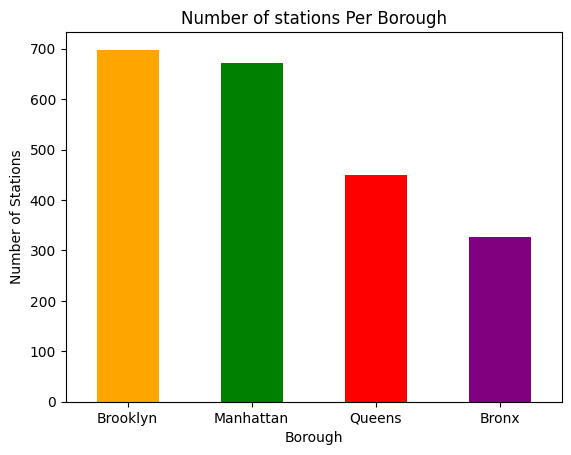

In [10]:
# Colors for trip time plot
colors_trip_times = ['orange', 'green', 'red', 'purple']
# Create plot
trip_time_plot = station_info["borough"].value_counts().plot.bar(
    color=colors_trip_times, title="Number of stations Per Borough", xlabel="Borough", ylabel="Number of Stations", rot=0, legend=False)
# Save plot as image
trip_time_plot.get_figure().savefig("img/borough_station_count_graph.png")


It appears that the Bronx has  significantly less stations than any other borough, indicating that more stations should be created there.

## Question Two
_When are bikers most actively riding bikes?_

In order to find when bikers are most active, we will show categorize each ride's `start_time` field into morning, afternoon, evening, and night.  The hours of of these times of days are defined [here](https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc)

|Part of Day|Time Interval|
|:---:|:---:|
|Morning|05:00:00 - 11:59:59|
|Afternoon|12:00:00 - 16:59:59|
|Evening|17:00:00 - 20:59:59|
|Night|21:00:00 - 04:59:59|

In [11]:
def time_categorizer(row):
    """
    time_categorizer: Gets the start time of a ride and categorizes it to morning, afternoon, evening, or night
    input: dataframe row
    output: time of day of a trip as a string
    """
    
    start_time = row['start_time']
    hour = start_time.hour
    if hour > 4 and hour < 12: 
        time_of_day = "morning"
    elif hour > 11 and hour < 17:
        time_of_day = "afternoon"
    elif hour > 16 and hour < 21:
        time_of_day = "evening"
    else:
        time_of_day = "night"
    return time_of_day
    
df['time_of_day'] = df.apply(time_categorizer, axis=1)

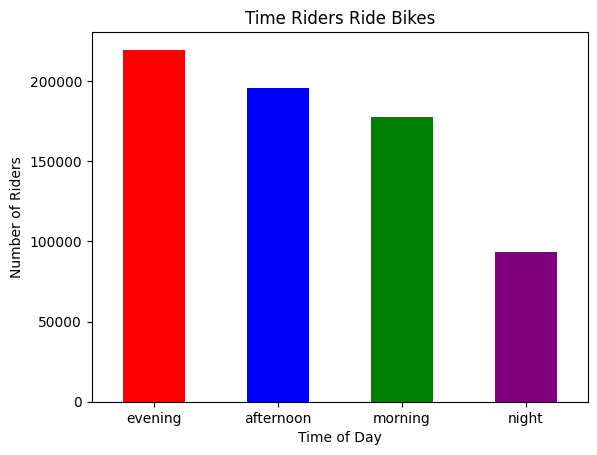

In [12]:
# Get the counts of time of day riders ride bikes
time_of_day_counts = df['time_of_day'].value_counts()
# Colors for time of day riders ride bikes plot
colors_time_of_day_counts = ['red', 'blue', 'green', 'purple']
# Create time of day riders ride bikes plot
time_riders_ride_plot = time_of_day_counts.plot.bar(color=colors_time_of_day_counts, rot=0, title="Time Riders Ride Bikes", xlabel="Time of Day", ylabel="Number of Riders")
## Save time of day riders ride bikes plot
time_riders_ride_plot.get_figure().savefig("img/time_riders_ride_bike_graph.png")

Not surprisingly, for the month of July, the evening is the most popular time to ride bikes, as it is after the business day and the temperature is typically cooler.

## Question Three
_Which stations receive bikes from the most stations? Which stations send bikes to the most stations?_

In order to capture this, we will create a graph data structure whose nodes are the stations and edges represent individual trips between stations. Each edge is weighted by the number of bikes going into and out of a station. Therefore, computing node in-degree and out-degree allows us to understand how many bikes go into or out of a station.

In [13]:
# Get a list the count of each station for when they start or end a trip
trips = df[["start_station_id", "end_station_id"]].groupby(["start_station_id", "end_station_id"], as_index=False).value_counts()
tuple_mapper = lambda row: (row["start_station_id"], row["end_station_id"], {"trip_count": row['count']})
x = list(trips.apply(tuple_mapper, axis=1))

In [14]:
# Create graph data structure
g = nx.DiGraph()
g.add_edges_from(x)

In [29]:
# Get in degrees and out degrees
in_degrees = dict(g.in_degree())
in_degrees = pd.Series(in_degrees.values(), index=in_degrees.keys())
in_degrees = in_degrees.sort_values(ascending=False).head(5)

out_degrees = dict(g.out_degree())
out_degrees = pd.Series(out_degrees.values(), index=out_degrees.keys())
out_degrees = out_degrees.sort_values(ascending=False).head(5)

In [50]:
# Get coordinates for in and out degree
in_coordinates = station_info.loc[station_info['short_name'].isin(in_degrees.keys()), ['short_name', 'lat', 'lon']]
in_coordinates['degree'] = 'in'
out_coordinates = station_info.loc[station_info['short_name'].isin(out_degrees.keys()), ['short_name', 'lat', 'lon']]
out_coordinates['degree'] = 'out'
degree_coor = pd.concat([in_coordinates, out_coordinates])

In [48]:
# ---- MAKING MAPS ----
# <i class="fa-solid fa-person-biking"></i>
# <i class="fa-solid fa-person"></i>
kw_in ={"prefix": "fa", "color": "blue", "icon": "person-biking"}
kw_out ={"prefix": "fa", "color": "green", "icon": "person-biking"}
m = folium.Map(tiles='https://{s}.basemaps.cartocdn.com/rastertiles/voyager_labels_under/{z}/{x}/{y}{r}.png',
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
   location=test_loc, zoom_start=15)
for index, row in degree_coor.iterrows():
    lat = row.lat
    lon = row.lon
    tooltip = row.degree
    if row.degree == 'in':
        folium.Marker(
        location=[lat, lon],
        tooltip=tooltip,
        icon=folium.Icon(**kw_in),).add_to(m)
    else:
        folium.Marker(
        location=[lat, lon],
        tooltip=tooltip,
        icon=folium.Icon(**kw_out),).add_to(m)
m

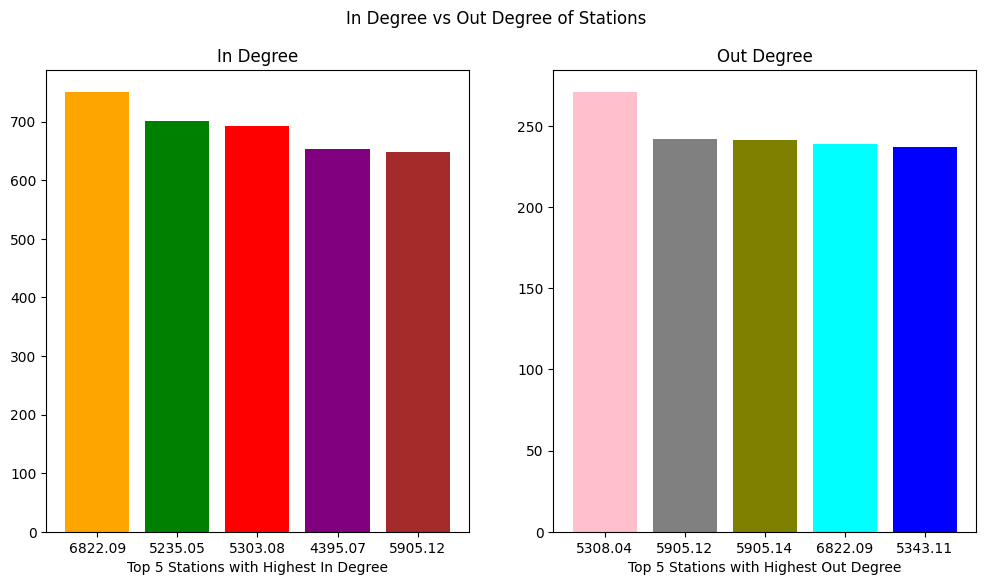

In [16]:
# Colors of degree graphs
colors_in_degree = ['orange', 'green', 'red', 'purple', 'brown']
colors_out_degree = ['pink', 'gray', 'olive', 'cyan', 'blue']
# Create figure for graph
fig, (ax_one, ax_two) = plt.subplots(1, 2, figsize=(12, 6))
# Create graphs
fig.suptitle("In Degree vs Out Degree of Stations")
ax_one.bar(in_degrees.index, in_degrees, color=colors_in_degree)
ax_two.bar(out_degrees.index, out_degrees, color=colors_out_degree)
ax_one.set_title("In Degree")
ax_one.set_xlabel('Top 5 Stations with Highest In Degree')
ax_two.set_title("Out Degree")
ax_two.set_xlabel('Top 5 Stations with Highest Out Degree')

# Save graph as image
plt.savefig("img/degree_measure.png")
plt.show()

On the left, we can see which stations have the most bikes being parked, while the right shows the most popular stations for taking bikes. The fact that these stations are different indicates that bikes do not naturally reallocate to their original stations through rider activity.

## Question Four
_Can we identify any monotonic relationships for future modeling?_

This is an important question as it helps determine if our data exhibits relationships that can serve as the foundation for a machine learning or statistical model.

In [17]:
# Get a list of columns we do not need for analysis
col_to_delete = df.columns.to_series()
col_to_delete = col_to_delete.filter(regex="(end)|(_date$)|(_at$)|(_name$)|(_time$)|(ride_id)|(_borough$)")
# Drop columns
data = df.drop(col_to_delete, axis=1)

In [18]:
# Get dummies for time of day
data = pd.get_dummies(data, columns=["time_of_day"], drop_first=True, dtype=int)

In [19]:
station_ids = list(station_info['short_name'])
# Index stations
station_ids = pd.DataFrame(enumerate(station_ids), columns=["id", "short_name"])
# Merge stations and their indexes
data = data.merge(station_ids, left_on="start_station_id", right_on="short_name")
# Drop unecessary columns
data.drop(labels=["start_station_id", "short_name"], inplace=True, axis=1)

### Correlation Matrix

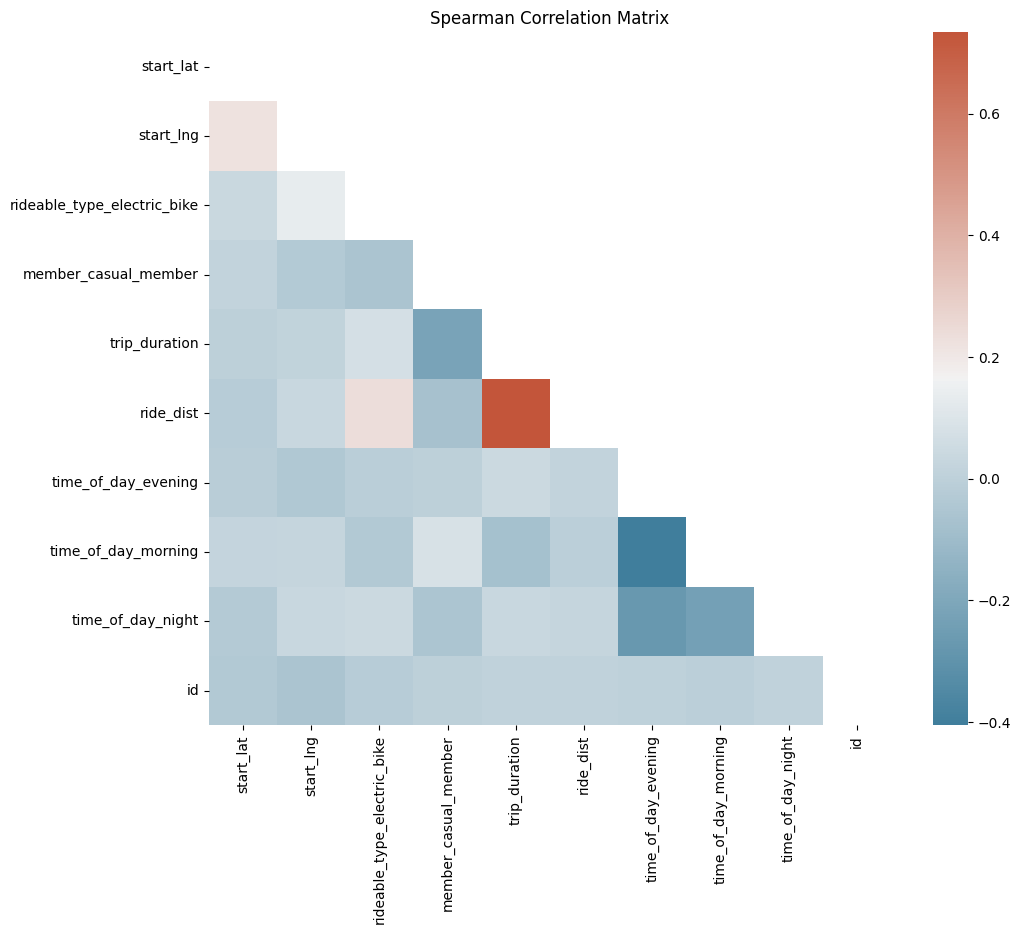

In [20]:
# Get Spearman matrix
spearman_corr = data.corr("spearman")
# Generate plot for spearman matrix
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(spearman_corr, mask=mask, cmap=cmap)
ax.set_title("Spearman Correlation Matrix")
# Save image of spearman matrix
plt.savefig("img/correlation_matrix.png")
plt.show()

The Spearman correlation matrix allows us to determine whether variables exhibit a monotonic relationship. Since the majority of the data is only weakly monotonic, models that can handle non-linear relationships, such as decision trees and neural networks, might be more viable for prediction.

# Results, Limitations, Future Work
Due to the weak monotonic relationships, more data needs to be collected, analyzed, and modeled. The historical ridership data for July 2024 spans over five datasets. In future work, we aim to utilize data-intensive technologies such as Apache Spark to transform larger volumes of data for analysis. Additionally, we only analyzed one month of data. Further analysis is required to gain a better overall understanding of rider behavior throughout the year.